In [1]:
from datasets import load_dataset

ds = load_dataset("luli0034/music-tags-to-spectrogram", split='train')

/home/akovel/Documents/HSE/Music-Predictor/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MIN_NUM_GENRES = 40

In [3]:
print(ds)

Dataset({
    features: ['image', 'text'],
    num_rows: 1543
})


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer


## Так выглядит спектограмма 

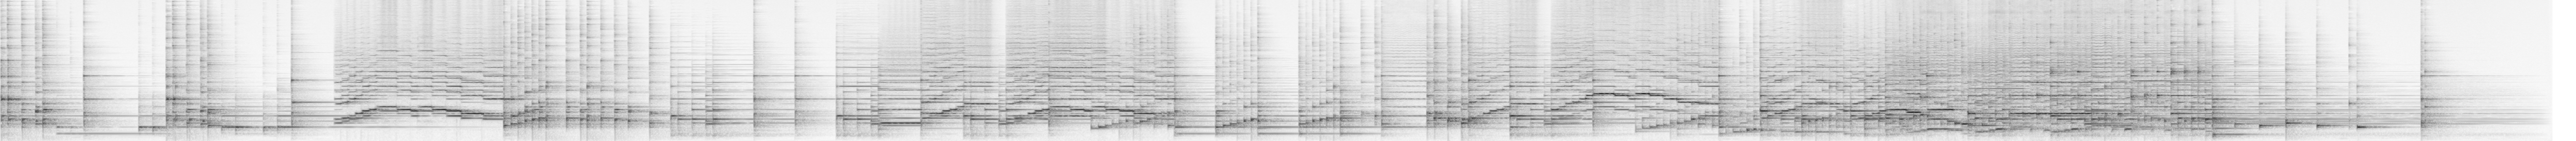

In [5]:
ds[0]["image"]

In [6]:
ds[0]["image"].size

(9371, 512)

## Где-то здесь сломанное изображение. Удалим

In [7]:
nums_to_delete = []
texts = []
for i in range(len(ds)):
    try:
        texts.append(ds[i]['text'])
    except Exception as e:
        nums_to_delete.append(i - len(nums_to_delete))
        print(nums_to_delete)

[939]


In [8]:
ds = ds.select(
    (
        i for i in range(len(ds)) 
        if i not in set(nums_to_delete)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x7ff48c15b840> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [9]:
ds

Dataset({
    features: ['image', 'text'],
    num_rows: 1542
})

In [10]:
all_genres = ds.remove_columns('image')

In [11]:
df = pd.DataFrame(data=all_genres)

### Жанры выглядят так

In [12]:
df.head()

text
0                soundtrack classical
1             hiphop electronic latin
2  poprock instrumentalrock rocknroll
3        soundtrack ambient classical
4        soundtrack ambient classical

In [13]:
mlb = MultiLabelBinarizer()
genres = mlb.fit_transform(df['text'])

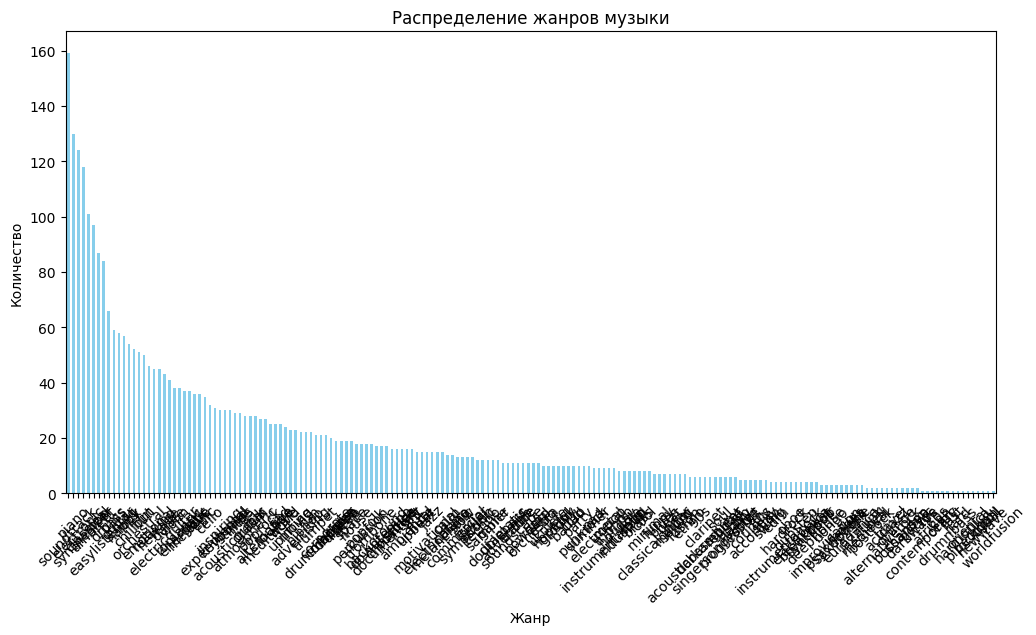

In [14]:
genres = df['text'].str.get_dummies(sep=' ').sum().sort_values(ascending=False)
genres.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Распределение жанров музыки')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

## Слишком много жанров

In [15]:
df['num_genres'] = df['text'].str.split(' ').apply(len)
print(df['num_genres'].value_counts())

num_genres
1     557
2     404
3     377
4     111
5      59
6      18
7       5
8       5
20      3
10      3
Name: count, dtype: int64


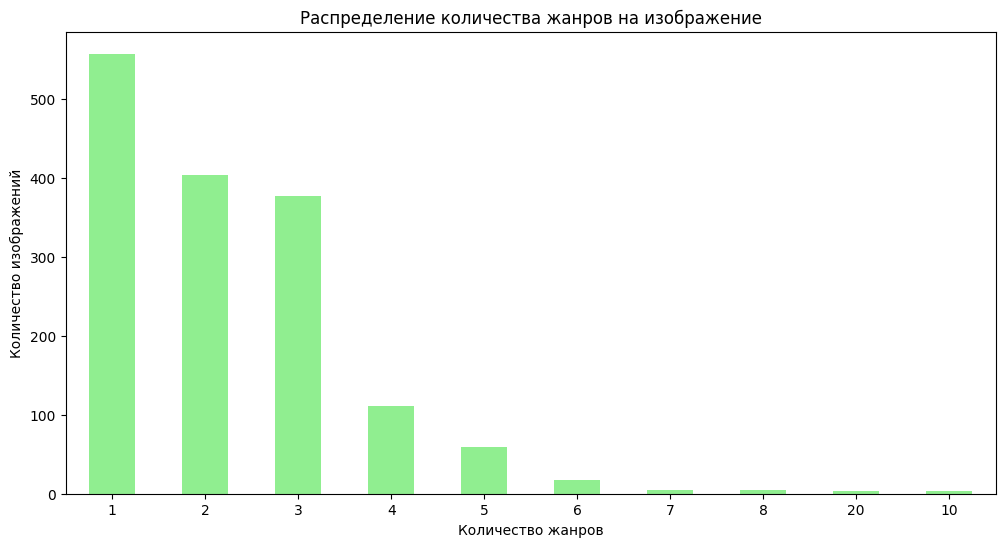

In [16]:
num_genres_distribution = df['num_genres'].value_counts()
num_genres_distribution.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Распределение количества жанров на изображение')
plt.xlabel('Количество жанров')
plt.ylabel('Количество изображений')
plt.xticks(rotation=0)
plt.show()

In [17]:
genre_counts = df['text'].str.split(expand=True).stack().value_counts()

rare_genres = genre_counts[genre_counts < MIN_NUM_GENRES].index
rare_genres

Index(['violin', 'romantic', 'melodic', 'energetic', 'love', 'dark', 'epic',
       'cello', 'experimental', 'keyboard',
       ...
       'contemporary', 'worldfusion', 'hard', 'celtic', 'oriental',
       'drumnbass', '70s', '60s', 'harmonica', 'fast'],
      dtype='object', length=163)

In [18]:
def filter_genres(text):
    genres = text.split()
    return ' '.join([genre for genre in genres if genre not in rare_genres])

df['text'] = df['text'].apply(filter_genres)

# df = df[df['text'] != '']

print(df)

                              text  num_genres
0             soundtrack classical           2
1                       electronic           3
2                                            3
3     soundtrack ambient classical           3
4     soundtrack ambient classical           3
...                            ...         ...
1537                      relaxing           2
1538                     emotional           1
1539                                         2
1540                                         2
1541                                         1

[1542 rows x 2 columns]


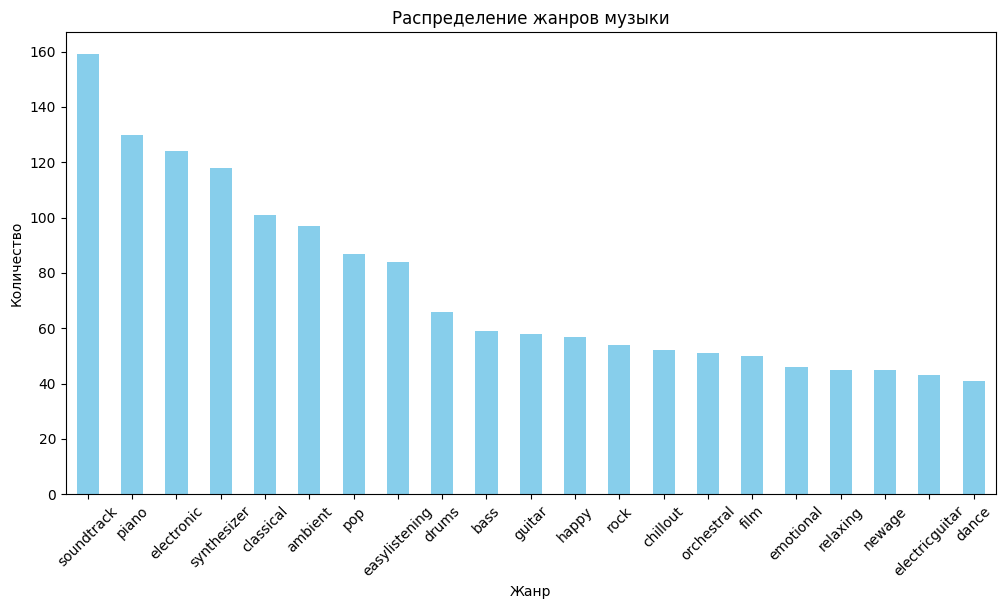

In [19]:
genres = df['text'].str.get_dummies(sep=' ').sum().sort_values(ascending=False)
genres.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Распределение жанров музыки')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

## По итогу оставили 22 жанра. И не уменьшили датасет

In [20]:
ds[2]['text']

'poprock instrumentalrock rocknroll'

In [21]:
df.iloc[2]['text']

''

In [27]:
len(df["text"].to_list())

1542

In [40]:
arr = df["text"].to_list()

In [ ]:
upd_ds = ds.add_column(name="simple_genre", column=arr)

Flattening the indices:   0%|          | 0/1542 [00:00<?, ? examples/s]

ArrowInvalid: offset overflow while concatenating arrays

In [26]:
ds

Dataset({
    features: ['image', 'text'],
    num_rows: 1542
})

In [ ]:
ds.save_to_disk('spectograms')

Saving the dataset (25/25 shards): 100%|██████████| 1541/1541 [00:48<00:00, 31.74 examples/s]
